In [81]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
# class sklearn.model_selection.StratifiedKFold(n_splits=5,
#     shuffle=False, random_state=None)
from typing import Union, Tuple
import warnings
warnings.simplefilter('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [83]:
df = pd.read_csv('/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/data_for_revise/prediction/payments/支出金額予測のデータフレーム完成.csv')
df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,カット選択,カラー選択,トリートメント選択,パーマ選択,縮毛矯正選択,その他選択,ヘッドスパ選択,イルミナメニュー化の有無,Aujuaメニュー化の有無,addicthyメニュー化の有無,inoaメニュー化の有無,支出金額
0,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,0,0,0,0,0,0,0,0,0,4950
1,島根,松江,18,237,179,7,24,41,48,5.0,0.978,0,0,0,1,0,0,0,0,0,0,0,13990
2,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,1,0,0,0,0,0,0,0,0,4950
3,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,0,0,0,0,0,0,0,0,0,4950
4,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,0,0,0,0,0,0,0,0,0,4950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264093,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,1.000,0,0,0,0,0,0,1,0,0,0,0,5390
264094,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,1.000,0,0,0,0,0,0,1,0,0,0,0,4620
264095,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,1.000,1,0,0,0,0,0,0,0,0,0,0,3520
264096,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,1.000,1,0,0,0,0,0,0,0,0,0,0,3520


In [84]:
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]
df_X[['県','エリア']]=df_X[['県','エリア']].astype('category')

In [85]:
class ContinuousStratifiedKFold:
    def __init__(self, n_split: int=5, shuffle: bool=True, random_state: int=42) -> None:
        self.n_split = n_split
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X: pd.DataFrame, reference: pd.Series, bins: int=10,
                      suffle: Union[bool]=None, random_state: Union[int]=None) -> Tuple[np.ndarray, np.ndarray]:

        shuffle = shuffle if suffle is not None else self.shuffle
        random_state = random_state if random_state is not None else self.random_state
        min_ref, max_ref = int(reference.min() - 1), int(reference.max() + 1)
        cut_threshold = np.linspace(min_ref, max_ref, bins)
        out = pd.cut(reference, bins=cut_threshold, labels=False)

        skf = StratifiedKFold(self.n_split, shuffle=shuffle, random_state=random_state)
        for train_idx, val_idx in skf.split(X, out):
            yield train_idx, val_idx

In [86]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 200,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
}

In [87]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=df_X, reference=df_y, bins=100)):
    X_train = df_X.loc[train_index, :]
    y_train = df_y[train_index]
    X_valid = df_X.loc[valid_index, :]
    y_valid = df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

0it [00:00, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[865]	valid_0's rmse: 1857.45


1it [00:07,  7.95s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[835]	valid_0's rmse: 1844.33


2it [00:16,  8.08s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[916]	valid_0's rmse: 1825.78


3it [00:24,  8.27s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[956]	valid_0's rmse: 1844.75


4it [00:33,  8.37s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[720]	valid_0's rmse: 1861.57


5it [00:39,  7.96s/it]


In [88]:
scores

[1857.4472714963435,
 1844.3336013176254,
 1825.7765154595618,
 1844.7464733485008,
 1861.5689767610363]

In [89]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=200, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=200, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=200, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=200, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=200, objective='regression',
               random_state=0)]

In [90]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,1857.447271,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,1844.333601,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,1825.776515,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,1844.746473,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,1861.568977,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


-419.09938310441635 26084.802651612208 26503.902034716626


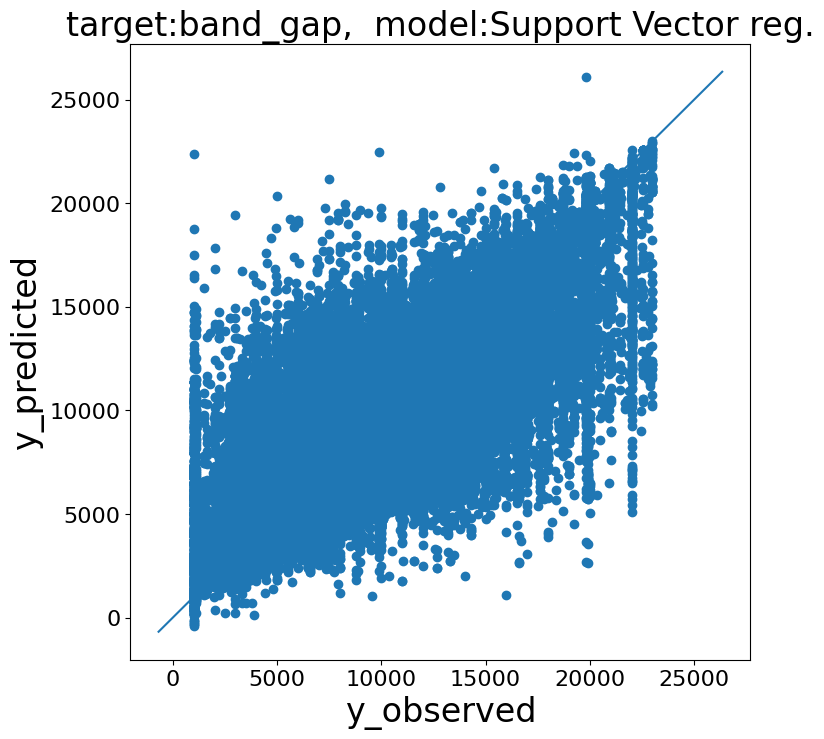

決定係数：0.765
RMSE：1846.82


In [91]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

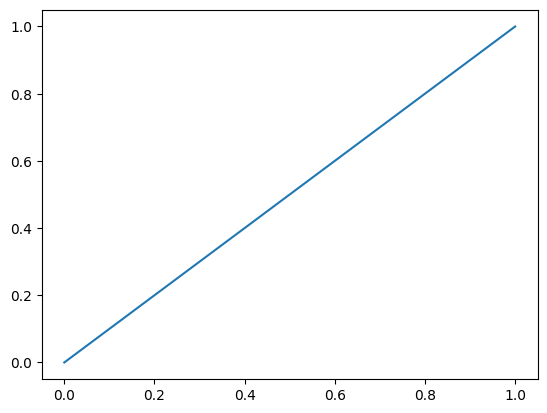

In [92]:
plt.plot([1, 0], [1,0])

In [93]:
df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,カット選択,カラー選択,トリートメント選択,パーマ選択,縮毛矯正選択,その他選択,ヘッドスパ選択,イルミナメニュー化の有無,Aujuaメニュー化の有無,addicthyメニュー化の有無,inoaメニュー化の有無,支出金額
0,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,0,0,0,0,0,0,0,0,0,4950
1,島根,松江,18,237,179,7,24,41,48,5.0,0.978,0,0,0,1,0,0,0,0,0,0,0,13990
2,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,1,0,0,0,0,0,0,0,0,4950
3,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,0,0,0,0,0,0,0,0,0,4950
4,島根,松江,18,237,179,7,24,41,48,5.0,0.978,1,0,0,0,0,0,0,0,0,0,0,4950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264093,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,1.000,0,0,0,0,0,0,1,0,0,0,0,5390
264094,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,1.000,0,0,0,0,0,0,1,0,0,0,0,4620
264095,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,1.000,1,0,0,0,0,0,0,0,0,0,0,3520
264096,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,1.000,1,0,0,0,0,0,0,0,0,0,0,3520


In [115]:
import random
tmp_index = random.randint(1, 100000)

tmp_df_X = df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

55101    6600
Name: 支出金額, dtype: int64

In [116]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [117]:
print(round(_score), float(tmp_df_y))

6280 6600.0


In [120]:
import pickle
with open('/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/payments/payments_models.pkl', mode='wb') as p:
    pickle.dump(models, p)